In [1]:
!pip install qiskit-machine-learning

   ---------------------------------------- 0.0/6.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/6.5 MB ? eta -:--:--
   - -------------------------------------- 0.3/6.5 MB ? eta -:--:--
   --- ------------------------------------ 0.5/6.5 MB 1.2 MB/s eta 0:00:05
   ---- ----------------------------------- 0.8/6.5 MB 1.0 MB/s eta 0:00:06
   ------ --------------------------------- 1.0/6.5 MB 1.1 MB/s eta 0:00:05
   --------- ------------------------------ 1.6/6.5 MB 1.3 MB/s eta 0:00:04
   ----------- ---------------------------- 1.8/6.5 MB 1.4 MB/s eta 0:00:04
   ----------- ---------------------------- 1.8/6.5 MB 1.4 MB/s eta 0:00:04
   ------------ --------------------------- 2.1/6.5 MB 1.1 MB/s eta 0:00:04
   -------------- ------------------------- 2.4/6.5 MB 1.2 MB/s eta 0:00:04
   ---------------- ----------------------- 2.6/6.5 MB 1.2 MB/s eta 0:00:04
   ---------------- ----------------------- 2.6/6.5 MB 1.2 MB/s eta 0:00:04
   ----------------- ------------

  You can safely remove it manually.


In [8]:
from qiskit.version import VERSION
print(VERSION)


1.4.3


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from qiskit import  transpile
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel as QuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import EstimatorOptions

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [20]:
# Fix seed for reproducibility
np.random.seed(42)
# 🧠 Backend fallback strategy: use mock circuit as backend-free fallback
from qiskit import QuantumCircuit
backend = transpile(QuantumCircuit(4), basis_gates=['u', 'cx'])._layout  # dummy placeholder

In [21]:
# ✅ STEP 1: Load and Preprocess Breast Cancer Dataset
print("\nLoading Breast Cancer Dataset...")
data = load_breast_cancer()
X = data.data[:, :4]  # Limit to 4 features for quantum feasibility
y = data.target


Loading Breast Cancer Dataset...


In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


In [23]:
# ✅ STEP 2: QSVM with Multiple Feature Maps
# Note: Benchpress is NOT used due to Windows OS compatibility issue. Using transpile for benchmarking.
def evaluate_qsvm(X_train, X_test, y_train, y_test):
    feature_maps = {
        "ZZFeatureMap": ZZFeatureMap(feature_dimension=4, reps=2),
        "PauliFeatureMap": PauliFeatureMap(feature_dimension=4, reps=2, paulis=['X', 'Y', 'Z'])
    }

    results = {}
    for name, fmap in feature_maps.items():
        print(f"\n🔹 Evaluating QSVM with {name}...")
        kernel = QuantumKernel(feature_map=fmap)
        model = QSVC(quantum_kernel=kernel)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        acc = accuracy_score(y_test, preds)
        results[name] = acc
        print(classification_report(y_test, preds))
        print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
    return results

In [29]:
# ✅ STEP 3: Classical Machine Learning Baselines
def evaluate_classical_models(X_train, X_test, y_train, y_test):
    models = {
        "SVM (RBF)": SVC(kernel="rbf"),
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Decision Tree": DecisionTreeClassifier(max_depth=5),
        "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    }

    results = {}
    for name, model in models.items():
        print(f"\n🔸 Evaluating {name}...")
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        acc = accuracy_score(y_test, preds)
        results[name] = acc
        print(classification_report(y_test, preds))
        print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
    return results

In [30]:
# ✅ STEP 4: Quantum Circuit Benchmarking with Qiskit Transpile
def benchmark_feature_map(feature_map):
    sample_input = np.random.rand(4)
    circuit = feature_map.assign_parameters(sample_input)
    transpiled = transpile(circuit, basis_gates=['u', 'cx'])
    return {
        "depth": transpiled.depth(),
        "width": transpiled.width(),
        "gate_count": transpiled.count_ops()
    }


In [31]:
# ✅ STEP 5: Run Full Evaluation
print("\n========== RUNNING EXPERIMENT ON BREAST CANCER DATASET ==========")
q_results = evaluate_qsvm(X_train, X_test, y_train, y_test)
c_results = evaluate_classical_models(X_train, X_test, y_train, y_test)

print("\n📊 Quantum Model Accuracies:", q_results)
print("📊 Classical Model Accuracies:", c_results)

print("\n🔧 Circuit Benchmarking Results using Qiskit Transpile:")
zz_benchmark = benchmark_feature_map(ZZFeatureMap(4, reps=2))
pauli_benchmark = benchmark_feature_map(PauliFeatureMap(4, reps=2, paulis=['X', 'Y', 'Z']))
print("ZZFeatureMap:", zz_benchmark)
print("PauliFeatureMap:", pauli_benchmark)



========== RUNNING EXPERIMENT ON BREAST CANCER DATASET ==========

🔹 Evaluating QSVM with ZZFeatureMap...
              precision    recall  f1-score   support

           0       0.47      0.30      0.37        63
           1       0.66      0.81      0.73       108

    accuracy                           0.62       171
   macro avg       0.57      0.55      0.55       171
weighted avg       0.59      0.62      0.60       171

Confusion Matrix:
 [[19 44]
 [21 87]]

🔹 Evaluating QSVM with PauliFeatureMap...
              precision    recall  f1-score   support

           0       0.86      0.51      0.64        63
           1       0.77      0.95      0.85       108

    accuracy                           0.79       171
   macro avg       0.82      0.73      0.75       171
weighted avg       0.80      0.79      0.77       171

Confusion Matrix:
 [[ 32  31]
 [  5 103]]

🔸 Evaluating SVM (RBF)...
              precision    recall  f1-score   support

           0       0.90      0.86 

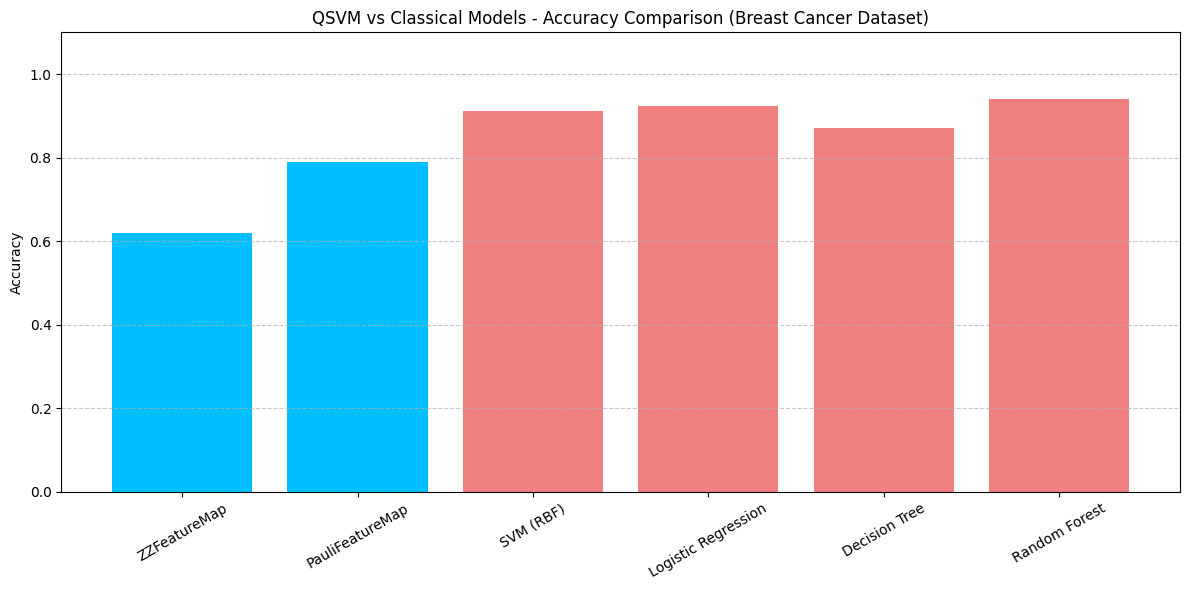

In [33]:
# ✅ STEP 6: Accuracy Visualization
labels = list(q_results.keys()) + list(c_results.keys())
values = list(q_results.values()) + list(c_results.values())
colors = ['deepskyblue'] * len(q_results) + ['lightcoral'] * len(c_results)

plt.figure(figsize=(12, 6))
plt.bar(labels, values, color=colors)
plt.title("QSVM vs Classical Models - Accuracy Comparison (Breast Cancer Dataset)")
plt.ylabel("Accuracy")
plt.xticks(rotation=30)
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
